Uncomment lines in the below cell to install data and software dependencies.

In [1]:
# !pip install --quiet quandl plotly git+https://github.com/ethho/memoize.git lmfit
# !mkdir -p ./data/final_proj
# !wget --quiet -O final_proj.py https://github.com/ethho/finm-33150/raw/main/final_proj.py
# !wget --quiet -O strat_returns.py https://github.com/ethho/finm-33150/raw/main/strat_returns.py
# !wget --quiet -O data/final_proj/uszcb.csv https://github.com/ethho/finm-33150/raw/main/data/final_proj/uszcb.csv

In [5]:
import os
import sys
import json
from glob import glob
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS, RollingWLS
import final_proj
import strat_returns

%matplotlib inline
# pd.options.display.float_format = '{:,.4f}'.format

DARK_MODE = False
if DARK_MODE:
    plt.style.use('dark_background')
    plotly_template = 'plotly_dark'
else:
    plt.style.use('ggplot')
    plotly_template = 'ggplot2'

# 20230308_p_model

Ethan Ho 3/8/2023

@mpcs
@finm

----

The purpose of this notebook is to analyze the PnL of Strategy 3-D.

## References

- [Project Outline](https://docs.google.com/document/d/1u4z5A9VYVPIAdJ36OfEpMQiQ67zj7iVXDmkjXtAMoIQ/edit#heading=h.f1f687128v9c).

# Helper Functions

In [56]:
def plot_pnl(strat_name, **kw):
    fp = f"./data/final_proj/{strat_name}_pnl.csv"
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    fig = px.line(
        df[[
            'pnl_pct', 'signal',
            'long_pnl_pct', 'short_pnl_pct'
        ]].rename({
        }),
        labels = {
            'date': 'Date',
            'value': 'PnL (% of $2 mil collateral<br>with 5x leverage)',
        },
        
        template=plotly_template,
        **kw
    )
    return fig

def plot_pnl_dist(strat_name, **kw):
    fp = f"./data/final_proj/{strat_name}_pnl.csv"
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    fig = px.histogram(
        df.loc[df['signal'] != 0., 'pnl_pct'],
        labels = {
            'date': 'Date',
            'value': 'PnL (% of $2 mil collateral with 5x leverage)',
        },
        # cumulative=True,
        histnorm='probability',
        template=plotly_template,
        **kw
    )
    fig.update_layout(showlegend=False)
    return fig

def plot_signal(strat_name, cols, **kw):
    fp = f"./data/final_proj/{strat_name}_signal.csv"
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    fig = px.line(
        df[cols].rename({
        }),
        labels = {
            'date': 'Date',
            'value': 'Value',
        },
        template=plotly_template,
        **kw
    )
    return fig

def parse_pnl_grid_search(strat_name, rf=0., **kw):
    pattern = f"./data/final_proj/{strat_name}_*_pnl.csv"
    results = dict()
    for fp in glob(pattern):
        stub = '_'.join(fp.split('_')[:-1])
        with open(f"{stub}_params.json", "r") as f:
            paramset = json.load(f)
        paramset['file_stub'] = os.path.basename(paramset['file_stub'])
        df = pd.read_csv(fp, index_col=0, parse_dates=True)
        results[stub] = {
            'df': df,
            **paramset,
            # Sharpe when we are not flat
            'sharpe': (df.loc[df['signal'] != 0, 'pnl'].mean() - rf) / df.loc[df['signal'] != 0, 'pnl'].std(),
            'n_trades': (df['signal'] != 0).sum(),
            'n_trades_short': (df['signal'] == -1).sum(),
            'n_trades_long': (df['signal'] == 1).sum(),
            'fig': px.scatter(
                df[[
                    'pnl_pct', 'signal',
                    'long_pnl_pct', 'short_pnl_pct'
                ]].rename({
                }),
                labels = {
                    'date': 'Date',
                    'value': 'PnL (% of $2 mil collateral<br>with 5x leverage)',
                },

                template=plotly_template,
                **kw
            ),
        }
    
    # Generate summary DataFrame
    sum_df = pd.DataFrame.from_records([{
        k: v for k, v in result.items()
        if k not in ('df', 'fig',)
    } for result in results.values()])
    sum_df.sort_values(by='sharpe', ascending=False, inplace=True)
    return {
        'sum_df': sum_df,
        'results_dict': results,
        # 'fig': fig
    }


def get_pred_df(strat_name, **kw):
    pnl_fp = f"./data/final_proj/{strat_name}_pnl.csv"
    sig_fp = f"./data/final_proj/{strat_name}_signal.csv"
    pnl = pd.read_csv(pnl_fp, index_col=0, parse_dates=True)
    sig = pd.read_csv(sig_fp, index_col=0, parse_dates=True)
    df = pnl.merge(sig, how='outer', left_index=True, right_index=True, suffixes=('_pnl', '_sig'))
    return df
    fig = px.line(
        df[cols].rename({
        }),
        labels = {
            'date': 'Date',
            'value': 'Value',
        },
        template=plotly_template,
        **kw
    )
    return fig


# Fetch Data

In [124]:
!python3 strat_returns.py

Using first non-null date as start_date='2001-08-29'
Using first non-null date as start_date='2001-08-29'
Wrote 'hedge_factors' to ./data/final_proj/strat_n1A_135_hedge_factors.csv
Wrote 'signal' to ./data/final_proj/strat_n1A_135_signal.csv
Wrote 'pnl' to ./data/final_proj/strat_n1A_135_pnl.csv
Wrote 'params' to ./data/final_proj/strat_n1A_135_params.json
Using first non-null date as start_date='2001-08-29'
Using first non-null date as start_date='2001-08-29'
Wrote 'hedge_factors' to ./data/final_proj/strat_n2A_0510_hedge_factors.csv
Wrote 'signal' to ./data/final_proj/strat_n2A_0510_signal.csv
Wrote 'pnl' to ./data/final_proj/strat_n2A_0510_pnl.csv
Wrote 'params' to ./data/final_proj/strat_n2A_0510_params.json
Using first non-null date as start_date='2001-08-29'
Using first non-null date as start_date='2001-08-29'
Wrote 'hedge_factors' to ./data/final_proj/strat_n2A_220_hedge_factors.csv
Wrote 'signal' to ./data/final_proj/strat_n2A_220_signal.csv
Wrote 'pnl' to ./data/final_proj/str

# Show Results of Grid Searches on Strategy 3-*

In [75]:
parse_pnl_grid_search(
    'strat_1B_135'
)['sum_df'].head(10)

,broker_borrow_rate,capital,file_stub,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
8,50,10000000,strat_1B_135_window_size102_sigma_thresh1.0,5.0,1.00,None,"[52.0, 156.0, 260.0]",102,0.683917,148,25,123
4,50,10000000,strat_1B_135_window_size102_sigma_thresh0.5,5.0,0.50,None,"[52.0, 156.0, 260.0]",102,0.555727,208,42,166
1,50,10000000,strat_1B_135_window_size102_sigma_thresh-0.5,5.0,-0.50,None,"[52.0, 156.0, 260.0]",102,0.539418,278,42,236
3,50,10000000,strat_1B_135_window_size102_sigma_thresh0.25,5.0,0.25,None,"[52.0, 156.0, 260.0]",102,0.531206,247,52,195
12,50,10000000,strat_1B_135_window_size102_sigma_thresh0,5.0,0.00,None,"[52.0, 156.0, 260.0]",102,0.502326,278,64,214
14,50,10000000,strat_1B_135_window_size52_sigma_thresh-0.5,5.0,-0.50,None,"[52.0, 156.0, 260.0]",52,0.394743,278,85,193
16,50,10000000,strat_1B_135_window_size52_sigma_thresh1.0,5.0,1.00,None,"[52.0, 156.0, 260.0]",52,0.383264,146,51,95
17,50,10000000,strat_1B_135_window_size52_sigma_thresh0.5,5.0,0.50,None,"[52.0, 156.0, 260.0]",52,0.375150,225,85,140
11,50,10000000,strat_1B_135_window_size52_sigma_thresh0.25,5.0,0.25,None,"[52.0, 156.0, 260.0]",52,0.369320,255,99,156
0,50,10000000,strat_1B_135_window_size26_sigma_thresh-0.5,5.0,-0.50,None,"[52.0, 156.0, 260.0]",26,0.355771,278,94,184


In [74]:
parse_pnl_grid_search(
    'strat_1C_135'
)['sum_df'].head(10)

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
9,50,10000000,0.60,strat_1C_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.533830,122,6,116
19,50,10000000,0.60,strat_1C_135_half_life6_window_size52_ci_alpha0.6,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.528992,120,13,107
18,50,10000000,0.40,strat_1C_135_half_life6_window_size52_ci_alpha0.4,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.525106,123,14,109
14,50,10000000,0.40,strat_1C_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.503192,125,6,119
24,50,10000000,0.60,strat_1C_135_half_life6_window_size26_ci_alpha0.6,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",26,0.502921,88,15,73
23,50,10000000,0.20,strat_1C_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.502407,131,6,125
30,50,10000000,0.40,strat_1C_135_half_life6_window_size26_ci_alpha0.4,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",26,0.495397,96,18,78
4,50,10000000,0.05,strat_1C_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.494485,139,7,132
16,50,10000000,0.20,strat_1C_135_half_life6_window_size52_ci_alpha0.2,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.488879,132,16,116
22,50,10000000,0.60,strat_1C_135_half_life12_window_size52_ci_alph...,12,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.482612,103,17,86


In [66]:
parse_pnl_grid_search(
    'strat_1D_135'
)['sum_df'].head(10)

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
10,50,10000000,0.60,strat_1D_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.855104,122,6,116
24,50,10000000,0.60,strat_1D_135_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.841362,102,3,99
9,50,10000000,0.60,strat_1D_135_half_life12_window_size52_ci_alph...,12,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.840927,103,17,86
7,50,10000000,0.60,strat_1D_135_half_life6_window_size52_ci_alpha0.6,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.839005,120,13,107
0,50,10000000,0.40,strat_1D_135_half_life6_window_size52_ci_alpha0.4,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",52,0.836673,123,14,109
21,50,10000000,0.20,strat_1D_135_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.832465,111,6,105
8,50,10000000,0.05,strat_1D_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.823971,139,7,132
12,50,10000000,0.20,strat_1D_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.817872,131,6,125
19,50,10000000,0.40,strat_1D_135_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.816625,125,6,119
3,50,10000000,0.40,strat_1D_135_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[52.0, 156.0, 260.0]",102,0.814012,104,4,100


In [76]:
parse_pnl_grid_search(
    'strat_2B_220'
)['sum_df'].head(10)

,broker_borrow_rate,capital,file_stub,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
6,50,10000000,strat_2B_220_window_size102_sigma_thresh-0.5,5.0,-0.50,None,"[104.0, 1040.0]",102,0.216403,278,113,165
0,50,10000000,strat_2B_220_window_size102_sigma_thresh0.5,5.0,0.50,None,"[104.0, 1040.0]",102,0.170627,236,113,123
15,50,10000000,strat_2B_220_window_size102_sigma_thresh0.25,5.0,0.25,None,"[104.0, 1040.0]",102,0.166226,262,124,138
3,50,10000000,strat_2B_220_window_size102_sigma_thresh0,5.0,0.00,None,"[104.0, 1040.0]",102,0.165969,278,133,145
14,50,10000000,strat_2B_220_window_size52_sigma_thresh-0.5,5.0,-0.50,None,"[104.0, 1040.0]",52,0.100235,278,121,157
10,50,10000000,strat_2B_220_window_size52_sigma_thresh0.5,5.0,0.50,None,"[104.0, 1040.0]",52,0.039823,230,121,109
11,50,10000000,strat_2B_220_window_size52_sigma_thresh0.25,5.0,0.25,None,"[104.0, 1040.0]",52,0.033634,247,133,114
8,50,10000000,strat_2B_220_window_size102_sigma_thresh1.0,5.0,1.00,None,"[104.0, 1040.0]",102,0.001854,132,66,66
17,50,10000000,strat_2B_220_window_size52_sigma_thresh0,5.0,0.00,None,"[104.0, 1040.0]",52,-0.009226,278,153,125
5,50,10000000,strat_2B_220_window_size26_sigma_thresh-0.5,5.0,-0.50,None,"[104.0, 1040.0]",26,-0.025409,278,114,164


In [67]:
parse_pnl_grid_search(
    'strat_2C_220'
)['sum_df'].head(10)

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
2,50,10000000,0.60,strat_2C_220_half_life6_window_size52_ci_alpha0.6,6,5.0,0.8,None,"[104.0, 1040.0]",52,1.238145,150,2,148
20,50,10000000,0.40,strat_2C_220_half_life6_window_size52_ci_alpha0.4,6,5.0,0.8,None,"[104.0, 1040.0]",52,1.017636,152,4,148
23,50,10000000,0.40,strat_2C_220_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[104.0, 1040.0]",102,0.983761,152,3,149
8,50,10000000,0.60,strat_2C_220_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[104.0, 1040.0]",102,0.979248,151,3,148
26,50,10000000,0.40,strat_2C_220_half_life6_window_size26_ci_alpha0.4,6,5.0,0.8,None,"[104.0, 1040.0]",26,0.969407,138,17,121
25,50,10000000,0.60,strat_2C_220_half_life6_window_size26_ci_alpha0.6,6,5.0,0.8,None,"[104.0, 1040.0]",26,0.964003,137,17,120
7,50,10000000,0.20,strat_2C_220_half_life6_window_size52_ci_alpha0.2,6,5.0,0.8,None,"[104.0, 1040.0]",52,0.937831,159,5,154
0,50,10000000,0.05,strat_2C_220_half_life6_window_size52_ci_alpha...,6,5.0,0.8,None,"[104.0, 1040.0]",52,0.890509,164,7,157
10,50,10000000,0.60,strat_2C_220_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[104.0, 1040.0]",102,0.874301,140,3,137
21,50,10000000,0.40,strat_2C_220_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[104.0, 1040.0]",102,0.805563,144,4,140


In [68]:
parse_pnl_grid_search(
    'strat_2D_220'
)['sum_df'].head(10)

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
14,50,10000000,0.60,strat_2D_220_half_life6_window_size52_ci_alpha0.6,6,5.0,0.8,None,"[104.0, 1040.0]",52,2.148104,150,2,148
13,50,10000000,0.40,strat_2D_220_half_life6_window_size52_ci_alpha0.4,6,5.0,0.8,None,"[104.0, 1040.0]",52,1.753329,152,4,148
2,50,10000000,0.20,strat_2D_220_half_life6_window_size52_ci_alpha0.2,6,5.0,0.8,None,"[104.0, 1040.0]",52,1.643608,159,5,154
28,50,10000000,0.40,strat_2D_220_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[104.0, 1040.0]",102,1.607585,152,3,149
30,50,10000000,0.60,strat_2D_220_half_life6_window_size102_ci_alph...,6,5.0,0.8,None,"[104.0, 1040.0]",102,1.595471,151,3,148
8,50,10000000,0.40,strat_2D_220_half_life6_window_size26_ci_alpha0.4,6,5.0,0.8,None,"[104.0, 1040.0]",26,1.561334,138,17,121
22,50,10000000,0.05,strat_2D_220_half_life6_window_size52_ci_alpha...,6,5.0,0.8,None,"[104.0, 1040.0]",52,1.553700,164,7,157
7,50,10000000,0.60,strat_2D_220_half_life6_window_size26_ci_alpha0.6,6,5.0,0.8,None,"[104.0, 1040.0]",26,1.550101,137,17,120
3,50,10000000,0.60,strat_2D_220_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[104.0, 1040.0]",102,1.502672,140,3,137
25,50,10000000,0.40,strat_2D_220_half_life12_window_size102_ci_alp...,12,5.0,0.8,None,"[104.0, 1040.0]",102,1.402182,144,4,140


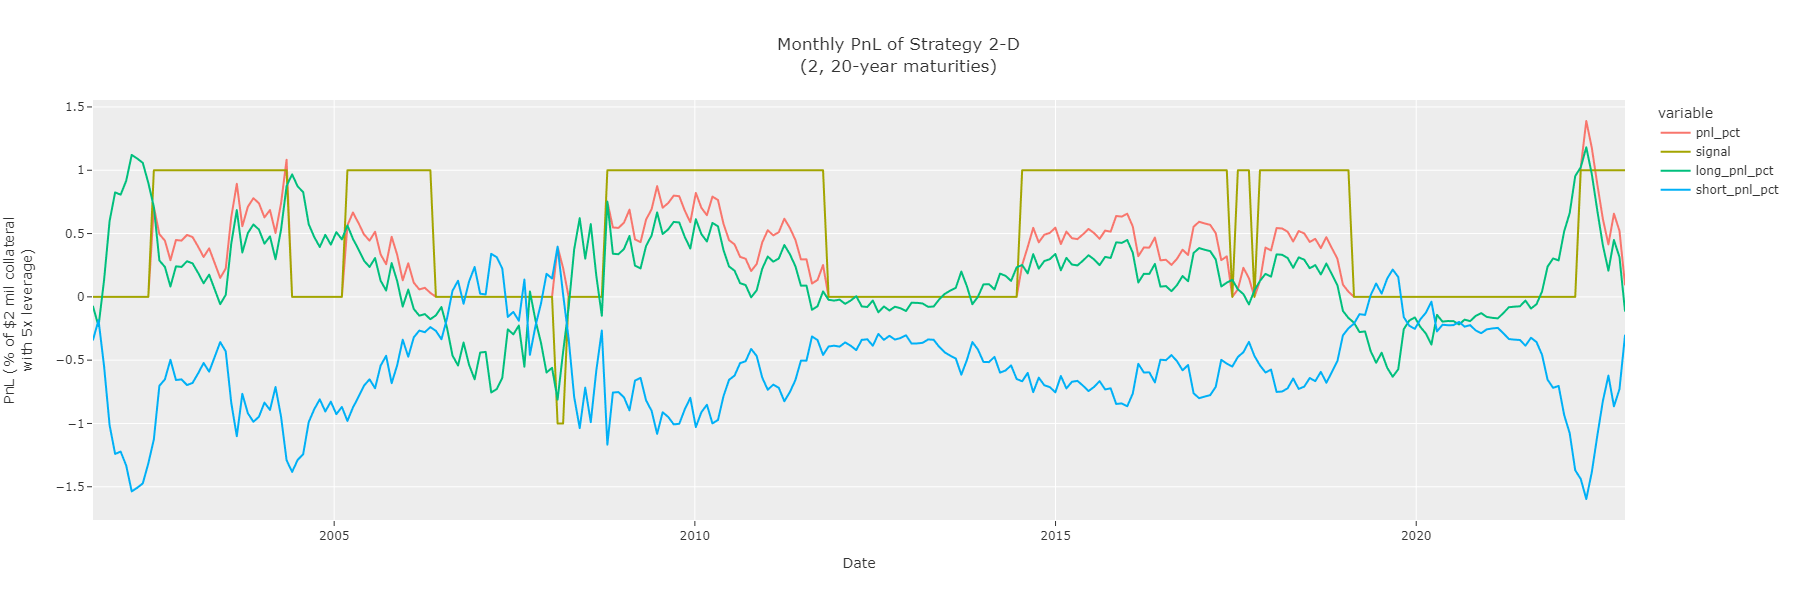

In [69]:
plot_pnl(
    'strat_2D_220_half_life6_window_size52_ci_alpha0.6',
    title=f'Monthly PnL of Strategy 2-D<br>(2, 20-year maturities)',
    height=600,
)

In [70]:
parse_pnl_grid_search(
    'strat_n3A_135',
)['sum_df'].head(10)

,broker_borrow_rate,capital,file_stub,leverage,sigma_thresh,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
10,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size102,5.0,0.25,None,"[52.0, 156.0, 260.0]",102,-0.082780,239,100,139
4,50,10000000,strat_n3A_135_sigma_thresh-0.5_window_size102,5.0,-0.50,None,"[52.0, 156.0, 260.0]",102,-0.089950,278,83,195
14,50,10000000,strat_n3A_135_sigma_thresh0_window_size102,5.0,0.00,None,"[52.0, 156.0, 260.0]",102,-0.091313,278,117,161
19,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size52,5.0,0.25,None,"[52.0, 156.0, 260.0]",52,-0.103904,244,95,149
2,50,10000000,strat_n3A_135_sigma_thresh1.0_window_size102,5.0,1.00,None,"[52.0, 156.0, 260.0]",102,-0.116298,93,48,45
13,50,10000000,strat_n3A_135_sigma_thresh0_window_size52,5.0,0.00,None,"[52.0, 156.0, 260.0]",52,-0.123442,278,105,173
0,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size26,5.0,0.25,None,"[52.0, 156.0, 260.0]",26,-0.126317,236,101,135
5,50,10000000,strat_n3A_135_sigma_thresh0_window_size26,5.0,0.00,None,"[52.0, 156.0, 260.0]",26,-0.126960,278,129,149
3,50,10000000,strat_n3A_135_sigma_thresh0.5_window_size102,5.0,0.50,None,"[52.0, 156.0, 260.0]",102,-0.127097,189,83,106
16,50,10000000,strat_n3A_135_sigma_thresh-0.5_window_size52,5.0,-0.50,None,"[52.0, 156.0, 260.0]",52,-0.130766,278,82,196


In [71]:
parse_pnl_grid_search(
    'strat_3C_135',
)['sum_df'].head(10)

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
24,50,10000000,0.6,strat_3C_135_half_life6_window_size13_ci_alpha0.6,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.356413,52,32,20
28,50,10000000,0.4,strat_3C_135_half_life6_window_size13_ci_alpha0.4,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.350737,64,36,28
7,50,10000000,0.6,strat_3C_135_half_life6_window_size102_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.322926,82,38,44
27,50,10000000,0.4,strat_3C_135_half_life6_window_size102_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.296577,89,42,47
1,50,10000000,0.6,strat_3C_135_half_life12_window_size13_ci_alph...,12,5.0,None,"[52.0, 156.0, 260.0]",13,0.290862,34,22,12
14,50,10000000,0.6,strat_3C_135_half_life6_window_size52_ci_alpha0.6,6,5.0,None,"[52.0, 156.0, 260.0]",52,0.264197,84,46,38
6,50,10000000,0.2,strat_3C_135_half_life6_window_size13_ci_alpha0.2,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.252737,77,42,35
16,50,10000000,0.4,strat_3C_135_half_life12_window_size13_ci_alph...,12,5.0,None,"[52.0, 156.0, 260.0]",13,0.250924,46,27,19
23,50,10000000,0.2,strat_3C_135_half_life6_window_size102_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.250289,98,48,50
5,50,10000000,0.6,strat_3C_135_half_life6_window_size26_ci_alpha0.6,6,5.0,None,"[52.0, 156.0, 260.0]",26,0.216063,64,42,22


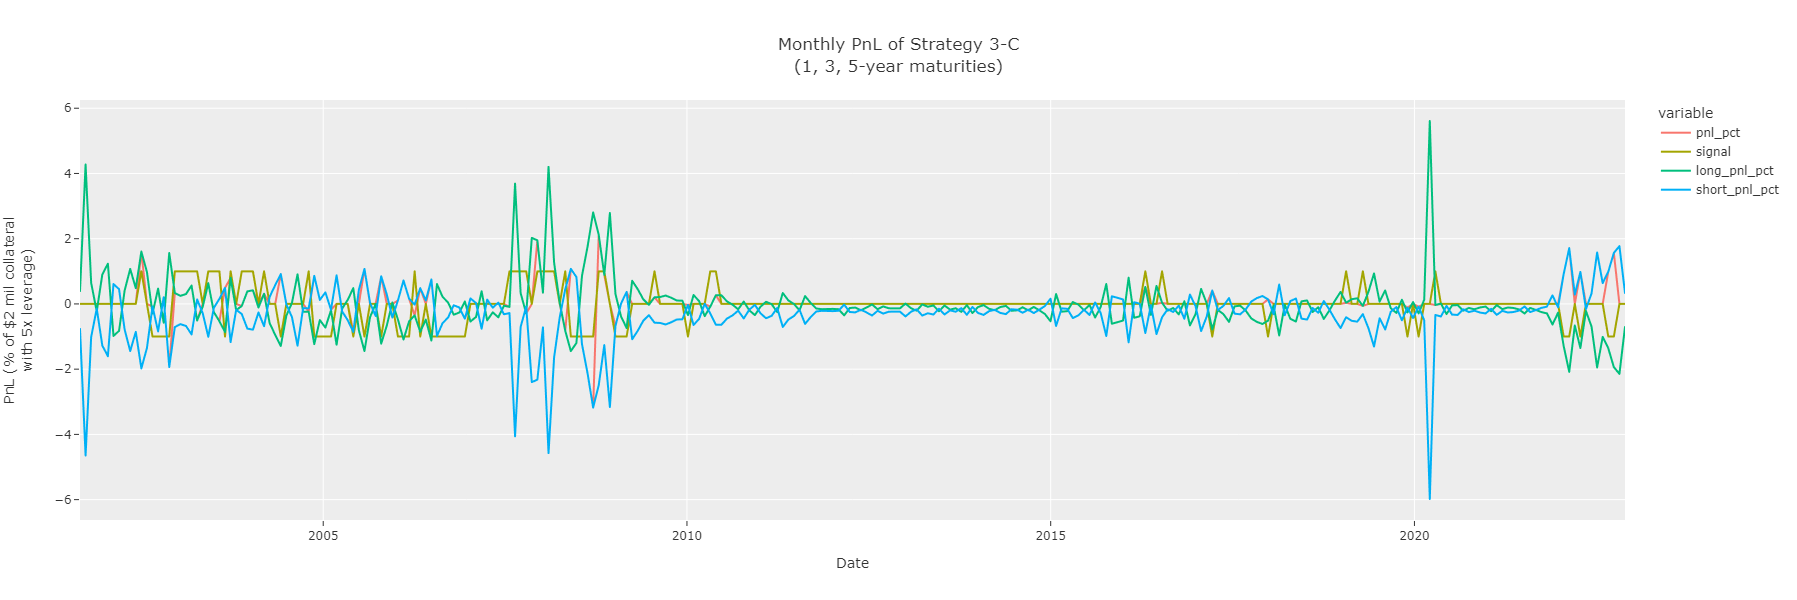

In [72]:
plot_pnl(
    'strat_3C_135_half_life6_window_size13_ci_alpha0.2',
    title=f'Monthly PnL of Strategy 3-C<br>(1, 3, 5-year maturities)',
    height=600,
)

# Plot Results of Strategy 3-D (1, 3, 5 year maturities) Grid Search

In [37]:
!ls data/final_proj/strat_3D*.csv

data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.05_hedge_factors.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.05_pnl.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.05_signal.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.2_hedge_factors.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.2_pnl.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.2_signal.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.4_hedge_factors.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.4_pnl.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.4_signal.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.6_hedge_factors.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.6_pnl.csv
data/final_proj/strat_3D_135_half_life12_window_size102_ci_alpha0.6_signal.csv
data/final_proj/strat_3D_135_half

In [64]:
gs_results = parse_pnl_grid_search(
    'strat_3D_135',
)
gs_results['sum_df'].head(10)

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,start_date,tenors,window_size,sharpe,n_trades,n_trades_short,n_trades_long
18,50,10000000,0.6,strat_3D_135_half_life6_window_size102_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.450774,82,38,44
24,50,10000000,0.4,strat_3D_135_half_life6_window_size13_ci_alpha0.4,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.441983,64,36,28
16,50,10000000,0.6,strat_3D_135_half_life6_window_size13_ci_alpha0.6,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.436403,52,32,20
28,50,10000000,0.4,strat_3D_135_half_life6_window_size102_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.422606,89,42,47
30,50,10000000,0.6,strat_3D_135_half_life6_window_size52_ci_alpha0.6,6,5.0,None,"[52.0, 156.0, 260.0]",52,0.384695,84,46,38
29,50,10000000,0.2,strat_3D_135_half_life6_window_size102_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.382043,98,48,50
19,50,10000000,0.6,strat_3D_135_half_life12_window_size13_ci_alph...,12,5.0,None,"[52.0, 156.0, 260.0]",13,0.357578,34,22,12
9,50,10000000,0.2,strat_3D_135_half_life6_window_size13_ci_alpha0.2,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.343176,77,42,35
13,50,10000000,0.6,strat_3D_135_half_life6_window_size26_ci_alpha0.6,6,5.0,None,"[52.0, 156.0, 260.0]",26,0.337315,64,42,22
7,50,10000000,0.4,strat_3D_135_half_life6_window_size52_ci_alpha0.4,6,5.0,None,"[52.0, 156.0, 260.0]",52,0.333322,93,53,40


Let's plot the PnL of the best parameter set in the grid search:

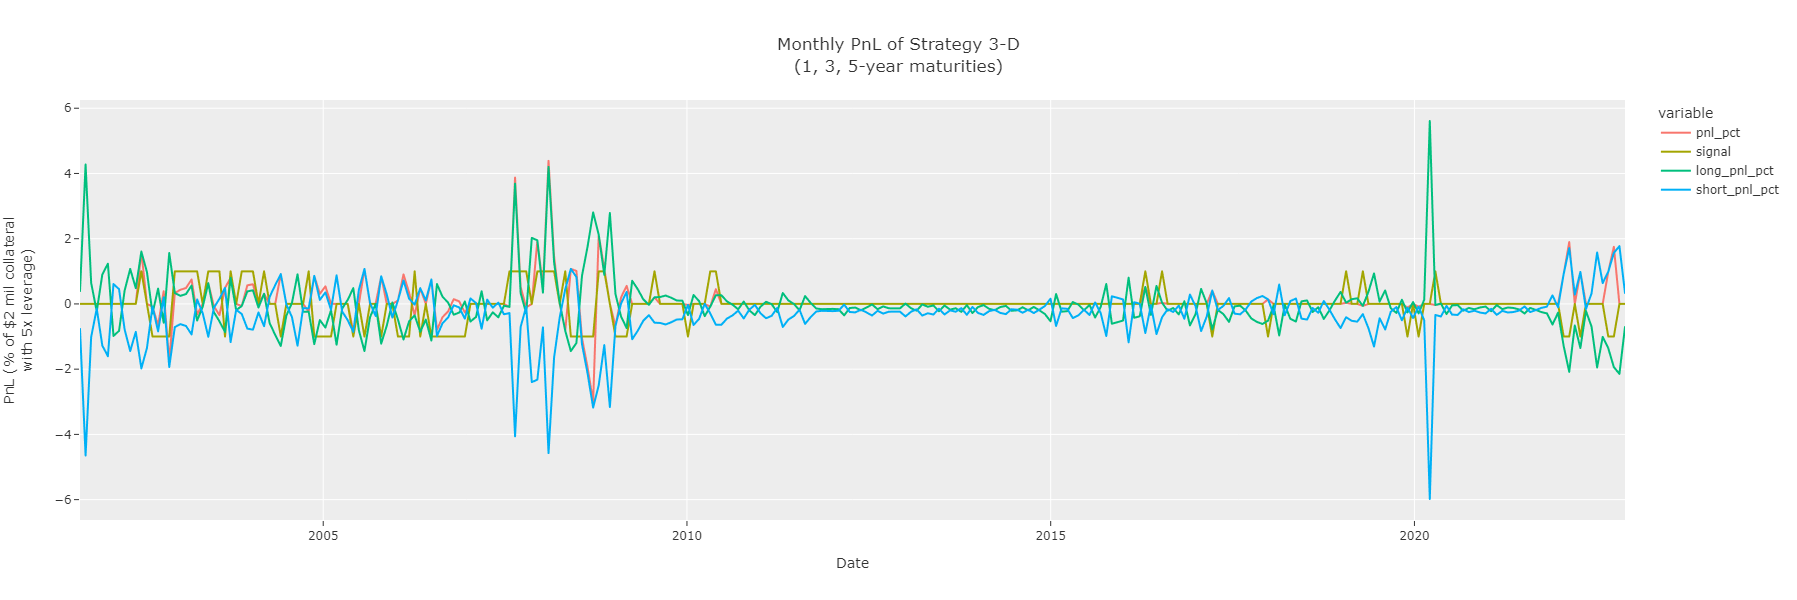

In [55]:
plot_pnl(
    'strat_3D_135_half_life6_window_size13_ci_alpha0.2',
    title=f'Monthly PnL of Strategy 3-D<br>(1, 3, 5-year maturities)',
    height=600,
)

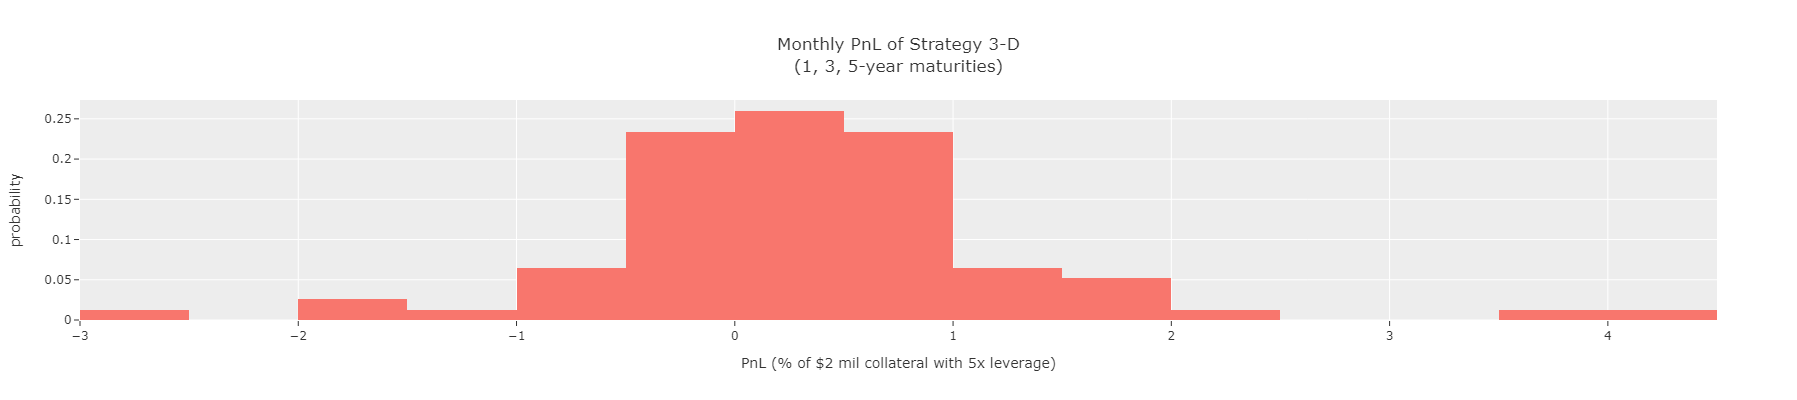

In [17]:
plot_pnl_dist(
    'strat_3D_135_half_life6_window_size13_ci_alpha0.2',
    title=f'Monthly PnL of Strategy 3-D<br>(1, 3, 5-year maturities)',
    nbins=30,
    height=400,
)

In [20]:
p3D_pdf = get_pred_df(
    'strat_3D_135_half_life6_window_size13_ci_alpha0.2',
    title=f'Trading Signal for Naive Strategy 2-A<br>(0.5 and 10 year maturities)',
)
p3D_pdf

,1,-1,0,pnl_no_fees,signal_pnl,pnl,pnl_pct,pnl_no_fees_pct,long_pnl_pct,short_pnl_pct,same_sig,mean,std,curv_z,ci_lower,ci_upper,ci_mid,pnl_no_fees_pred,pnl_pred,signal_sig
date,,,,,,,,,,,,,,,,,,,,
2001-08-29,7897.450595,-15341.237577,0,11619.344086,0,0.000000,0.000000,0.580967,0.394873,-0.767062,False,0.000016,0.000026,-0.363571,NaN,NaN,NaN,NaN,NaN,0
2001-09-26,85498.329052,-92942.116034,0,89220.222543,0,0.000000,0.000000,4.461011,4.274916,-4.647106,True,0.000016,0.000026,-0.640762,NaN,NaN,NaN,NaN,NaN,0
2001-10-24,12899.235916,-20343.022898,0,16621.129407,0,0.000000,0.000000,0.831056,0.644962,-1.017151,True,0.000016,0.000026,-0.351519,NaN,NaN,NaN,NaN,NaN,0
2001-11-21,-4582.359798,-2861.427184,0,-860.466307,0,0.000000,0.000000,-0.043023,-0.229118,-0.143071,True,0.000017,0.000026,0.265045,NaN,NaN,NaN,NaN,NaN,0
2001-12-19,18048.337836,-25492.124818,0,21770.231327,0,0.000000,0.000000,1.088512,0.902417,-1.274606,True,0.000025,0.000025,1.942371,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-03,-20211.426587,12767.639604,0,-16489.533095,0,0.000000,0.000000,-0.824477,-1.010571,0.638382,True,0.000056,0.000037,-1.485469,-1895.389986,336.935405,-779.227290,1157.518122,0.000000,0
2022-08-31,-27159.820604,19716.033622,0,-23437.927113,-1,19716.033622,0.985802,-1.171896,-1.357991,0.985802,False,0.000054,0.000040,-1.650173,588.345250,2799.068310,1693.706780,-2794.908668,-897.052584,-1
2022-09-28,-38739.361021,31295.574039,0,-35017.467530,-1,35017.467530,1.750873,-1.750873,-1.936968,1.564779,True,0.000053,0.000041,-0.879303,2346.753707,4851.789377,3599.271542,-3164.851997,-544.301799,-1


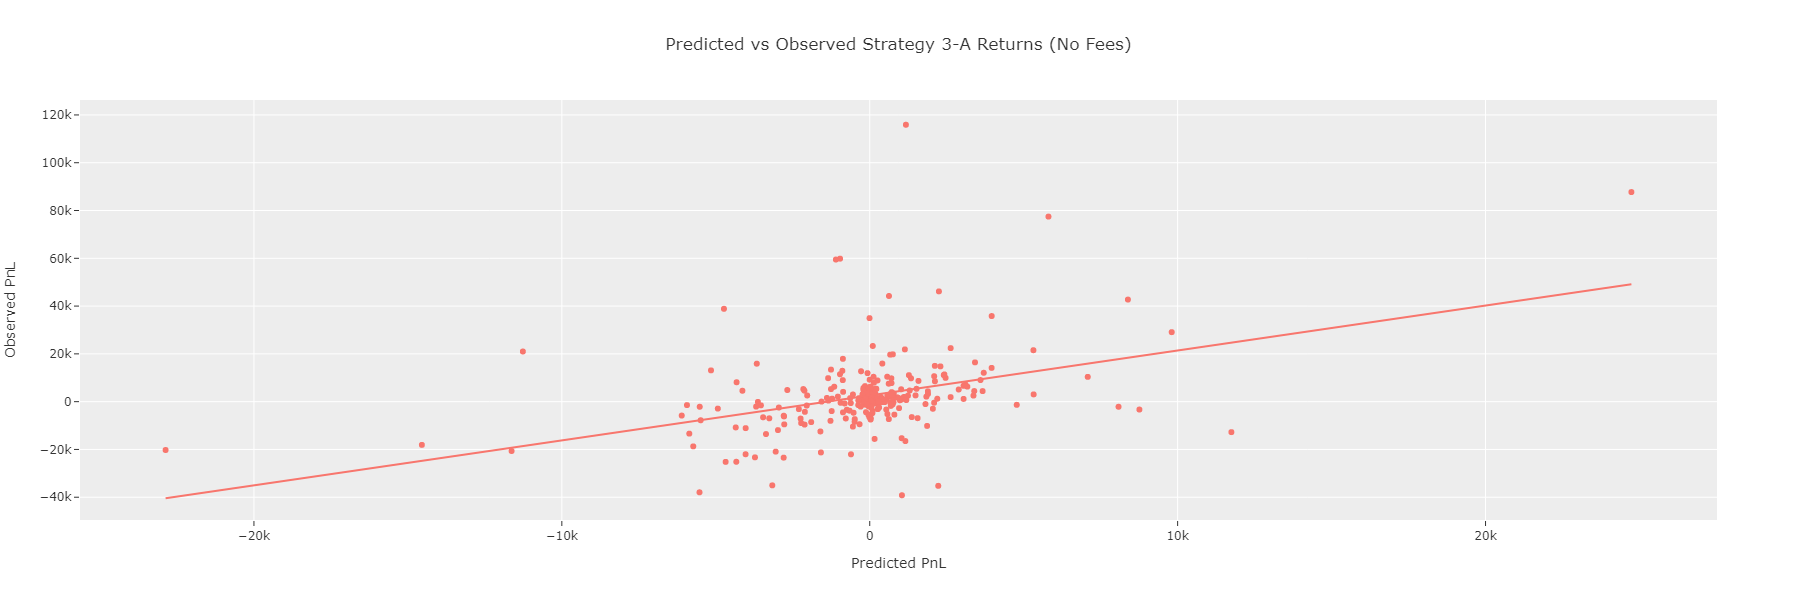

In [21]:
fig = px.scatter(
    p3D_pdf.rename(columns={
        'pnl_no_fees': 'Observed PnL',
        'pnl_no_fees_pred': 'Predicted PnL',
    }),
    y='Observed PnL',
    x='Predicted PnL',
    template=plotly_template,
    trendline='ols',
    title='Predicted vs Observed Strategy 3-A Returns (No Fees)',
    height=600,
    width=800,
)
# fig.update_xaxes(
#     scaleanchor="y",
#     scaleratio=6.,
# )
fig

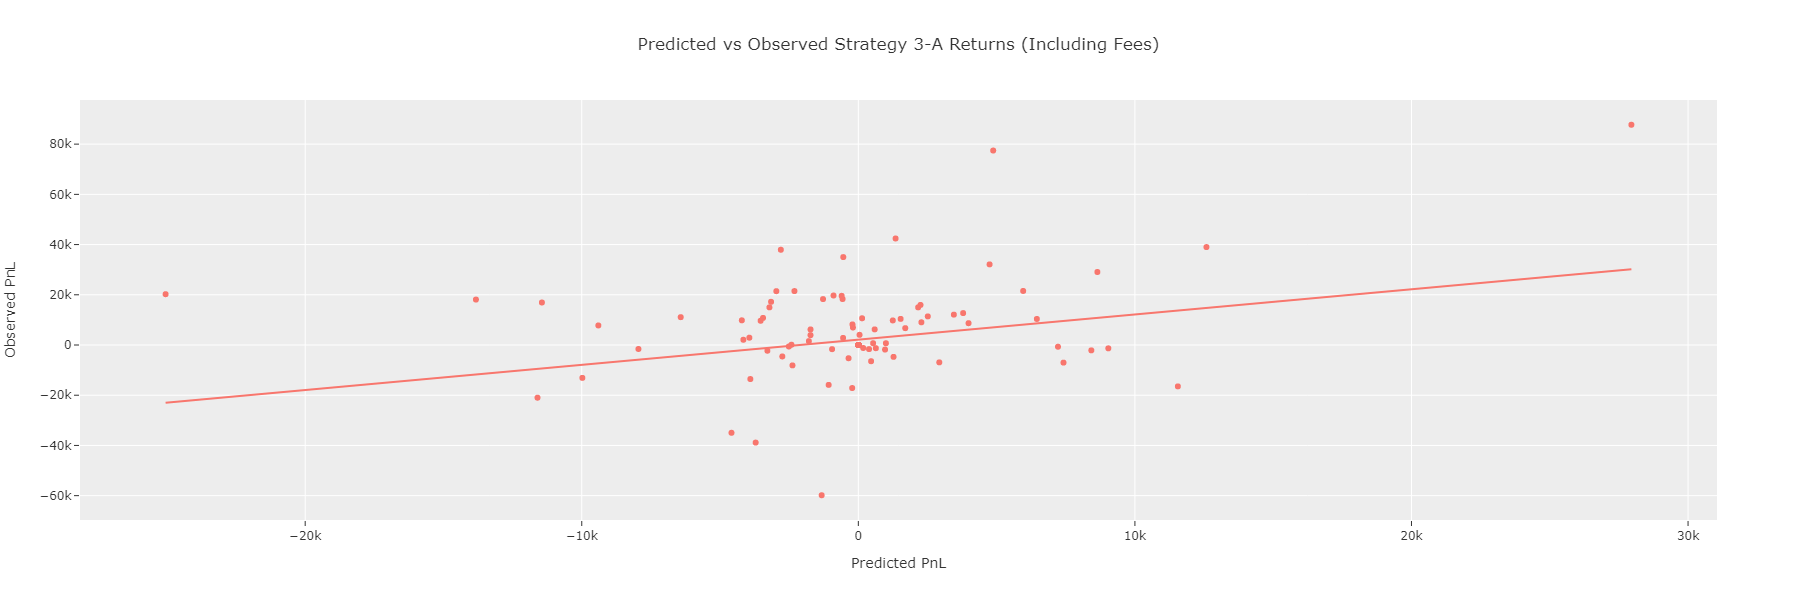

In [22]:
fig = px.scatter(
    p3D_pdf.rename(columns={
        'pnl': 'Observed PnL',
        'pnl_pred': 'Predicted PnL',
    }),
    y='Observed PnL',
    x='Predicted PnL',
    template=plotly_template,
    trendline='ols',
    title='Predicted vs Observed Strategy 3-A Returns (Including Fees)',
    height=600,
    width=800,
)
# fig.update_xaxes(
#     scaleanchor="y",
#     scaleratio=6.,
# )
fig